In [2]:
import warnings
from model.utils import *
from model.model import ThreeStageNetwork
import numpy as np
import torch
from PIL import Image

# Downloading Repo and Demo Data

In [ ]:
example = "https://drive.google.com/file/d/1bsevP0v7aZilet2PqkvN9ryqNf86hqXo/view?usp=sharing"


# Visualizing Embeddings

We will now have a look at how our trained model did on both the training and validation data by visualizing the embedings. To do this we will use UMAP to project our 512D embeddings down to 2 dimensions for plotting! We will then colour our labels and see whether we can spot any separation.

In [2]:
import matplotlib.pyplot as plt
from model.utils import umap_plot
import umap

We now load the embeddings and labels from the pretrained model dataset.

In [3]:
embed_logits = np.load("example/logits_embeds.npz")

In [4]:
from sklearn.metrics import classification_report

In [5]:
np.sum(np.argmax(embed_logits["vlogits"], axis=1) == embed_logits["vlabels"])/20200

0.801930693069307

In [6]:
tembeds = embed_logits["tembeds"]
tlabels = embed_logits["tlabels"]
vembeds = embed_logits["vembeds"]
vlabels = embed_logits["vlabels"]

In [7]:
def umap_plot(umap_embeddings,
              labels, 
              title,
              save_path=None, 
              save_plot=False):
    """
    This is primarily from Kevins hook example in pytorch-metric-learning library

    Inputs:
        umap_embeddings np.array - 2D embedding output from umap.UMAP()
        labels np.array - 1D labels associated with embeddings, used for colors
        save_path None or Str - where to save plots. See example Useage. If None
                                then plot is not saved.

    Example Useage:
        >>> e, l = get_embeddings([trunk, embedder], train_dataset)
        >>> lo, la = get_logits(classifier, e, l)
        >>> embeds = umap.UMAP().fit_transform(e)
        >>> umap_plot(embeds, l, save_path=None) # do not save image

        Or an example to save the plot, where epoch is our current epoch val
        >>> umap_plot(embeds, l, save_path=f"images/umap_train_epoch{epoch}")
    """
    label_set = np.unique(labels)
    # all this is for figure
    fig = plt.figure(figsize=(12,8))
    plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, len(label_set))]))
    for i in range(len(label_set)):
        idx = labels == label_set[i]
        plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=1)
        
    plt.axis("off")
    plt.title(title)
    if save_plot:
        plt.savefig(save_path, dpi=100)

    plt.show()

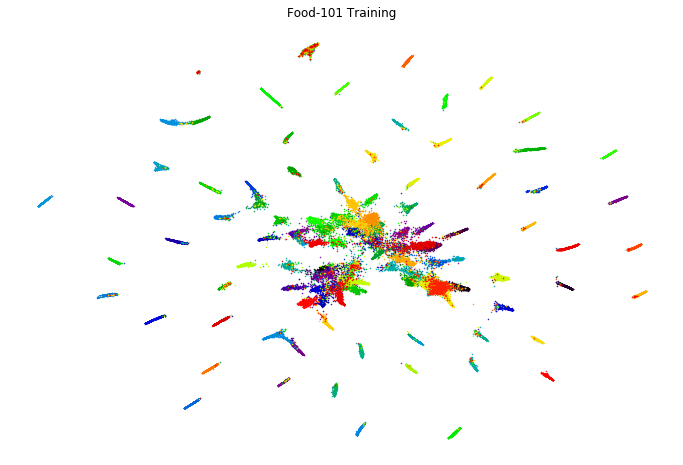

In [16]:
embeds = umap.UMAP().fit_transform(tembeds)
umap_plot(embeds, tlabels, "Food-101 Training", save_path="tembed.png", save_plot=True)

We can spot clear separation in our training data for a lot of classes, however the middle is very messy where our model failed to separate those classes.

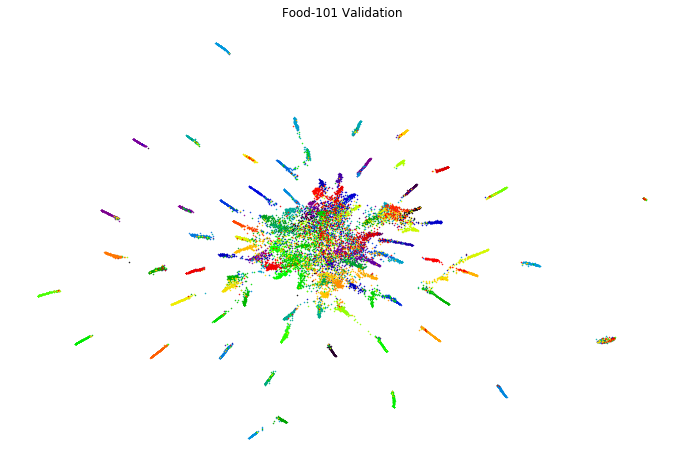

In [17]:
embeds = umap.UMAP().fit_transform(vembeds)
umap_plot(embeds, vlabels, "Food-101 Validation", save_path="vembed.png", save_plot=True)

The validation set tells a similar story, with slightly worse performance.

# Predicting on Unseen Data

Let's now go ahead and predict on unseen data. We can do this by just looking up some images of foods! For example we know that Apple Pie is a food within the Food-101 dataset.

In [8]:
im1 = Image.open("example/applepie1.jpg")
im2 = Image.open("example/applepie2.jpg")
im3 = Image.open("example/applepie3.png")
im4 = Image.open("example/applepie4.jpg")
the_array = [im1, im2, im3, im4]

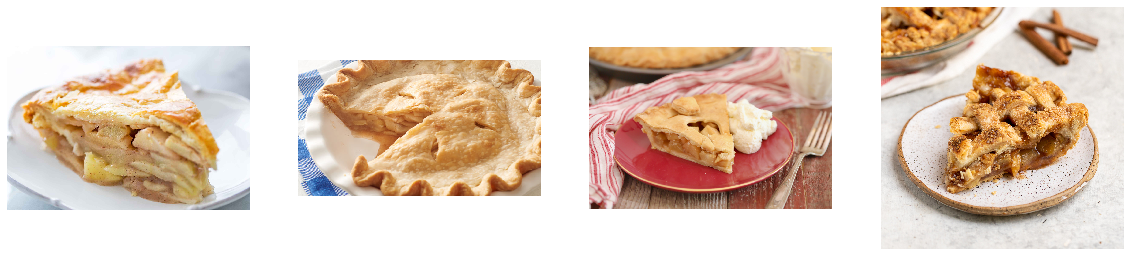

In [9]:
plt.figure(figsize=(20,10))

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(the_array[i])
    plt.axis("off")

plt.show()

In [10]:
model = ThreeStageNetwork(trunk_optim="SGD",
                          embedder_optim="SGD",
                          classifier_optim="SGD",
                          trunk_lr=1e-3,
                          embedder_lr=1e-3,
                          classifier_lr=1e-3,
                          log_train=False)

Loaded pretrained weights for efficientnet-b0


In [11]:
model.load_weights("example/models.h5")

In [12]:
from torchvision import datasets, transforms

In [13]:
transformations = [transforms.Resize(224),
                   transforms.CenterCrop(224),
                   transforms.ToTensor(),
                   transforms.Normalize([0.485, 0.456, 0.406],
                                        [0.229, 0.224, 0.225])]
val_transform = transforms.Compose(transformations)

In [14]:
embeds1, logits1 = model.image_inference(val_transform(im1).unsqueeze(0))
embeds2, logits2 = model.image_inference(val_transform(im2).unsqueeze(0))
embeds3, logits3 = model.image_inference(val_transform(im3).unsqueeze(0))
embeds4, logits4 = model.image_inference(val_transform(im4).unsqueeze(0))

We know that Apple Pie is class 0, so let's go ahead and see which classes we get for our images!

In [15]:
print(np.argmax(logits1.cpu().numpy()))
print(np.argmax(logits2.cpu().numpy()))
print(np.argmax(logits3.cpu().numpy()))
print(np.argmax(logits4.cpu().numpy()))

62
2
0
0


Half of them right, doesn't seem too great but remember our network is currently trained on 101 dishes from a very noisy dataset.

# Fine Tuning and Predicting again

Let's now fine tune on a new smaller dataset that was webscraped.

In [16]:
del model
torch.cuda.empty_cache()

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
directories = ["pepperoni pizza", "hamburger", "spaghetti", "waffle",
               "dumplings", "english breakfast", "coffee", "katsu curry",
               "salad", "club sandwich"]
path = "example/clean_dataset/"

image_paths = []
categories = []

for directory in directories:
    ims = os.listdir(path + directory)
    for im in ims:
        image_paths.append(path + directory + "/" + im)
        categories.append(directory)
        
# now make encoded labels
labels = LabelEncoder().fit_transform(categories)

Let's have a look at some of the images!


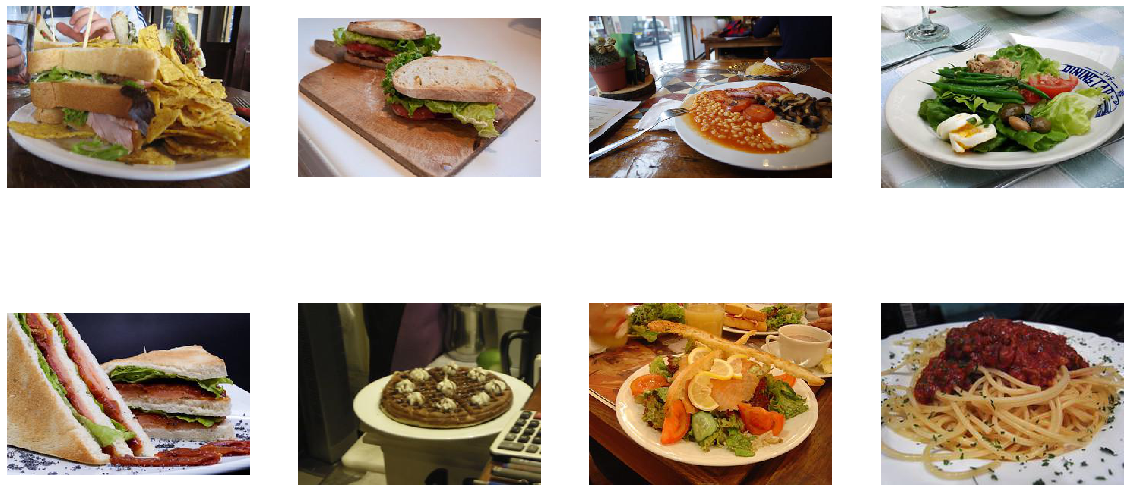

In [10]:
plt.figure(figsize=(20,10))

np.random.seed(2)
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(Image.open(np.random.choice(image_paths)))
    plt.axis("off")

plt.show()

In [11]:
class NewData(torch.utils.data.Dataset):
    def __init__(self, h5_path=None, transform=None):
        """
        Inputs:
            h5_path (Str): specifying path of HDF5 file to load
            transform (torch transforms): if None is skipped, otherwise torch
                                          applies transforms
        """
        self.transform = transform

    def __getitem__(self, index):
        """
        Method for pulling images and labels from the initialized HDF5 file
        """
        X = Image.open(image_paths[index])
        y = labels[index]

        if self.transform is not None:
            X = self.transform(X)
        return X, y

    def __len__(self):
        return len(labels)

Now we only have 10 classes, so we change the output of the classifier to 10 neurons and do not load the classifier weights

In [13]:
model = ThreeStageNetwork(num_classes=10,
                          trunk_optim="SGD",
                          embedder_optim="SGD",
                          classifier_optim="SGD",
                          trunk_lr=1e-3,
                          embedder_lr=1e-3,
                          classifier_lr=1e-3,
                          log_train=False)

Loaded pretrained weights for efficientnet-b0


In [14]:
model.load_weights("example/models.h5", load_classifier=False)

In [15]:
model.setup_data(dataset=NewData,
                 batch_size=48,
                 load_indices=False,
                 num_workers=0,
                 labels = labels,
                 indices_path="logs/data_indices.npz")

C:\Users\alexi\Desktop\metriclearning\model\model.py:357: UserWarning: Picking random indices, dangerous if you are continuing training!
  warnings.warn("Picking random indices, dangerous if you are continuing training!")


Let's also have a quick look at the embedding space prior to training on the entire dataset.

In [16]:
tembeds, _, tlabels, tacc = model.get_embeddings_logits(model.val_dataset, 
                                                        np.arange(len(model.labels)), 
                                                        batch_size=64,
                                                        num_workers=0)

Getting Embeddings



logits shape (2741, 10)
Accuracy is 0.06555781044317684


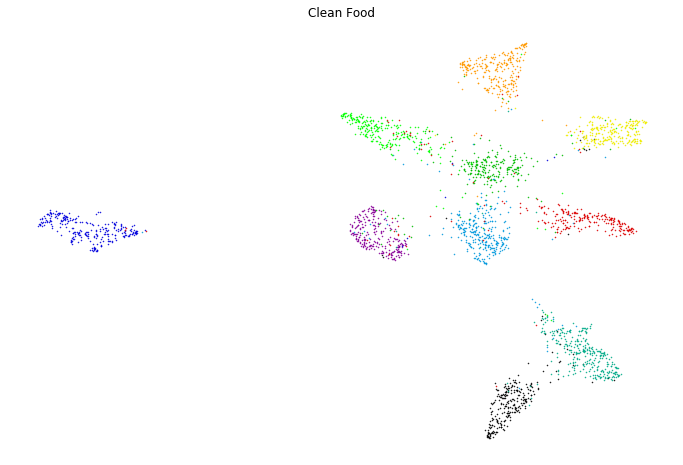

In [17]:
embeds = umap.UMAP().fit_transform(tembeds)
umap_plot(embeds, tlabels, "Clean Food", save_path="cleanfood.png", save_plot=False)

We can clearly see that this new data which has not been seen before is very well separated. Let's run kmeans on it and see what kind of accuracy we get.

In [18]:
from sklearn.cluster import KMeans

In [19]:
kmeans_clusters = KMeans(n_clusters=10).fit_predict(tembeds)

Since the returned cluster labels do not match with our labels, what we do is write a quick function to pick the most frequent occuring label at the label position in tlabel.

In [20]:
def get_label(lab):
    return np.bincount(kmeans_clusters[np.where(tlabels == lab)[0]]).argmax()

Build the mapping dictionary.

In [21]:
label_encode = {}
for i in range(10):
    label_encode[get_label(i)] = i

In [22]:
for i in range(len(kmeans_clusters)):
    kmeans_clusters[i] = label_encode[kmeans_clusters[i]]

Now let's look at a classification report of how well we perform prior to doing any training.

In [23]:
print(classification_report(kmeans_clusters, tlabels))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89       223
           1       1.00      0.67      0.80       362
           2       0.91      1.00      0.95       246
           3       0.90      0.87      0.88       337
           4       0.89      0.91      0.90       313
           5       0.88      0.76      0.82       293
           6       0.84      0.96      0.90       236
           7       0.99      0.88      0.93       275
           8       0.96      0.97      0.97       269
           9       0.68      0.97      0.80       187

    accuracy                           0.88      2741
   macro avg       0.89      0.90      0.88      2741
weighted avg       0.90      0.88      0.88      2741



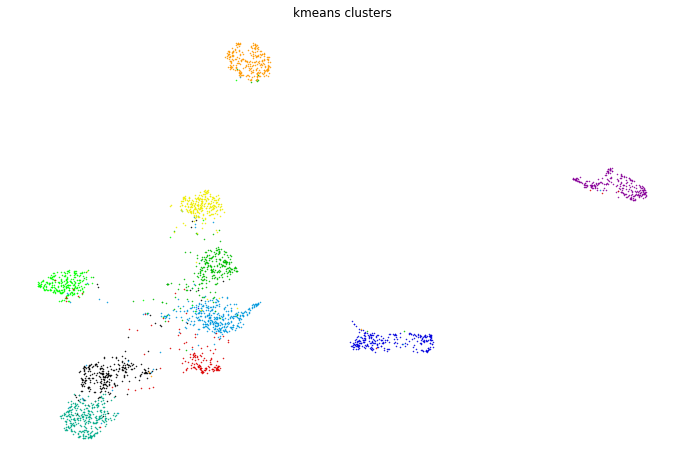

In [33]:
umap_plot(embeds, kmeans_clusters, title="kmeans clusters")

In [34]:
def kmean(n, embeds):
    
    kmeans_clusters = KMeans(n_clusters=n).fit_predict(embeds)
    label_encode = {}
    
    for i in range(n):
        label_encode[np.bincount(kmeans_clusters[np.where(tlabels == i)[0]]).argmax()] = i
        
    for i in range(len(kmeans_clusters)):
        kmeans_clusters[i] = label_encode[kmeans_clusters[i]]
        
    return kmeans_clusters

Now let's fine tune and see if we can do better.

In [24]:
import gc
gc.collect()

model = None

with torch.no_grad():
    torch.cuda.empty_cache()
    
gc.collect()

537

In [25]:
model = ThreeStageNetwork(num_classes=10,
                          trunk_optim="SGD",
                          embedder_optim="SGD",
                          classifier_optim="SGD",
                          trunk_lr=1e-5,
                          embedder_lr=1e-4,
                          classifier_lr=1e-3,
                          log_train=False)

model.load_weights("example/models.h5", load_classifier=False)

model.setup_data(dataset=NewData,
                 batch_size=28,
                 load_indices=True,
                 num_workers=0,
                 M=4,
                 repeat_indices=10,
                 train_split=0.05,
                 labels = labels,
                 indices_path="example/datasets/5_class_0.npz")

print(len(model.train_indices))
print(np.bincount(model.labels[model.train_indices]))

model.train(n_epochs=5,
            loss_ratios=[1,1,1,3],
            model_save_path="example",
            model_name="finetuned_0.1.h5")

Loaded pretrained weights for efficientnet-b0
50
[5 5 5 5 5 5 5 5 5 5]
Starting training with 5 Epochs.


Running Sampler


..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)



{'Load_Data': 3.73, 'Forward_Pass': 1.52, 'Mining': 1.45, 'Compute_Loss': 2.58, 'Optim_Step': 5.92, 'Logging': 0.48, 'Total': 15.68}
Training
Getting Embeddings



logits shape (50, 10)
Accuracy is 0.84
Validation
Getting Embeddings



logits shape (2192, 10)
Accuracy is 0.6741071428571429


Running Sampler

{'Load_Data': 3.48, 'Forward_Pass': 1.28, 'Mining': 1.87, 'Compute_Loss': 2.33, 'Optim_Step': 7.9, 'Logging': 0.45, 'Total': 17.31}
Training
Getting Embeddings



logits shape (50, 10)
Accuracy is 0.98
Validation
Getting Embeddings



logits shape (2192, 10)
Accuracy is 0.8433035714285715


Running Sampler

{'Load_Data': 3.26, 'Forward_Pass': 1.12, 'Mining': 2.39, 'Compute_Loss': 2.17, 'Optim_Step': 9.96, 'Logging': 0.54, 'Total': 19.43}
Training
Getting Embeddings



logits shape (50, 10)
Accuracy is 1.0
Validation
Getting Embeddings



logits shape (2192, 10)
Accuracy is 0.8683035714285714


Running Sampler



KeyboardInterrupt: 

In [39]:
tembeds, _, tlabels, tacc = model.get_embeddings_logits(model.val_dataset, 
                                                        model.train_indices, 
                                                        batch_size=64, 
                                                        num_workers=0)

Getting Embeddings



logits shape (50, 10)
Accuracy is 1.0


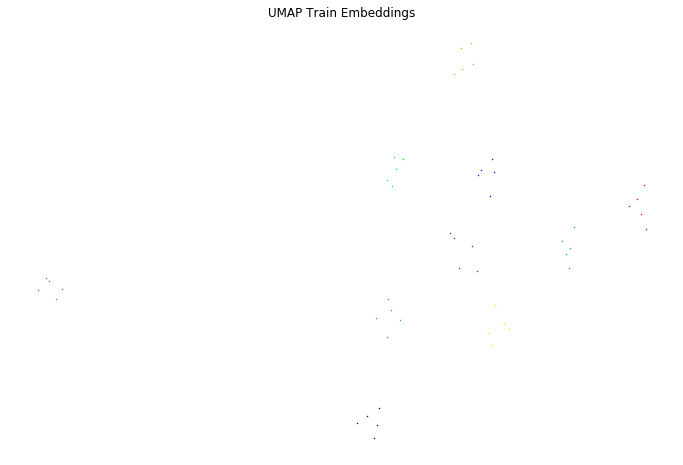

In [41]:
embeds = umap.UMAP().fit_transform(tembeds)
umap_plot(embeds, tlabels, title="UMAP Train Embeddings")

In [42]:
tembeds, _, tlabels, tacc = model.get_embeddings_logits(model.val_dataset, 
                                                        model.val_indices, 
                                                        batch_size=64, 
                                                        num_workers=0)

Getting Embeddings



logits shape (2192, 10)
Accuracy is 0.8830357142857143


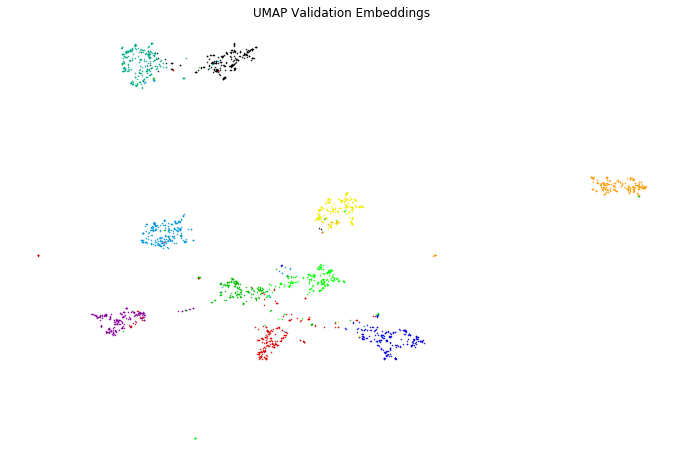

In [43]:
embeds = umap.UMAP().fit_transform(tembeds)
umap_plot(embeds, tlabels, title="UMAP Validation Embeddings")

Create 10 datasets for different amount of samples

In [65]:
# images_per_class = 150

# for images_per_class in [1, 3, 5, 10, 25, 50, 100, 150]:
#     for j in range(10):
#         train_ids = []
#         for i in range(10):
#             train_ids.append(np.random.choice(np.where(labels == i)[0], size=images_per_class))
#         train_ids = np.concatenate(train_ids, axis = 0)

#         left = np.setdiff1d(np.arange(len(labels)),
#                             train_ids)
#         val_ids = np.random.choice(left, size=int(len(labels)*0.8))
#         test_ids = np.setdiff1d(left,
#                                 val_ids)

#         np.savez(f"example/datasets/{images_per_class}_class_{j}.npz", 
#                  train=train_ids,
#                  val=val_ids,
#                  holdout=test_ids)

In [1]:
import os

In [2]:
def get_repeats(path):
    p = path.split("_")[0]
    
    if int(p) == 1:
        return 20
    elif int(p) == 3:
        return 20
    elif int(p) == 5:
        return 10
    elif int(p) == 10:
        return 5
    elif int(p) == 25:
        return 2
    else:
        return 1
        

In [3]:
a = os.listdir("example/datasets")

In [4]:
a

['100_class_0.npz',
 '100_class_1.npz',
 '100_class_2.npz',
 '100_class_3.npz',
 '100_class_4.npz',
 '100_class_5.npz',
 '100_class_6.npz',
 '100_class_7.npz',
 '100_class_8.npz',
 '100_class_9.npz',
 '10_class_0.npz',
 '10_class_1.npz',
 '10_class_2.npz',
 '10_class_3.npz',
 '10_class_4.npz',
 '10_class_5.npz',
 '10_class_6.npz',
 '10_class_7.npz',
 '10_class_8.npz',
 '10_class_9.npz',
 '150_class_0.npz',
 '150_class_1.npz',
 '150_class_2.npz',
 '150_class_3.npz',
 '150_class_4.npz',
 '150_class_5.npz',
 '150_class_6.npz',
 '150_class_7.npz',
 '150_class_8.npz',
 '150_class_9.npz',
 '1_class_0.npz',
 '1_class_1.npz',
 '1_class_2.npz',
 '1_class_3.npz',
 '1_class_4.npz',
 '1_class_5.npz',
 '1_class_6.npz',
 '1_class_7.npz',
 '1_class_8.npz',
 '1_class_9.npz',
 '25_class_0.npz',
 '25_class_1.npz',
 '25_class_2.npz',
 '25_class_3.npz',
 '25_class_4.npz',
 '25_class_5.npz',
 '25_class_6.npz',
 '25_class_7.npz',
 '25_class_8.npz',
 '25_class_9.npz',
 '3_class_0.npz',
 '3_class_1.npz',
 '3_

In [5]:
import subprocess

In [6]:
from tqdm.auto import tqdm

In [ ]:
for dataset in tqdm(a):
    p = subprocess.Popen(["python", "experiments.py", "--load-weights", "True",
                    "--id-path", "example/datasets/" + dataset,
                    "--loss", "True", "--repeat", str(get_repeats(dataset))])
    p_status = p.wait()
    p = subprocess.Popen(["python", "experiments.py", "--load-weights", "False",
                    "--id-path", "example/datasets/"+dataset,
                    "--loss", "True", "--repeat", str(get_repeats(dataset))])
    p_status = p.wait()
    p = subprocess.Popen(["python", "experiments.py", "--load-weights", "True",
                    "--id-path", "example/datasets/"+dataset,
                    "--loss", "False", "--repeat", str(get_repeats(dataset))])
    p_status = p.wait()
    p = subprocess.Popen(["python", "experiments.py", "--load-weights", "False",
                    "--id-path", "example/datasets/"+dataset,
                    "--loss", "False", "--repeat", str(get_repeats(dataset))])
    p_status = p.wait()

In [20]:
!python experiments.py --load-weights True --id-path "example/datasets/100_class_0.npz" --loss True --repeat 1

^C
